# Load EMNIST Dataset from Kaggle

To use, attatch kaggle.json in content on colab

In [313]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [314]:
!kaggle datasets download -d crawford/emnist

emnist.zip: Skipping, found more recently modified local copy (use --force to force download)


In [315]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [316]:
import zipfile
zip_ref = zipfile.ZipFile('/content/emnist.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [317]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


class_mapping = ' ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [318]:
# Load training dataset
train_data = pd.read_csv('emnist-letters-train.csv', header=None)

# Load test dataset
test_data = pd.read_csv('emnist-letters-test.csv', header=None)

In [319]:
print(train_data.shape)
print(test_data.shape)

(88800, 785)
(14800, 785)


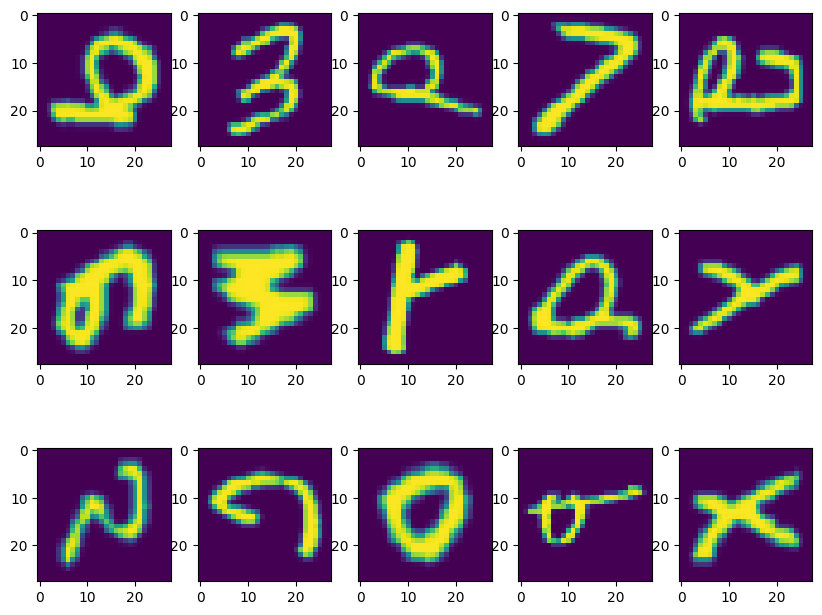

In [320]:
img_size = 28
x1 = np.array(train_data.iloc[:,1:].values)
indices = np.arange(len(x1))
np.random.shuffle(indices)
fig,axes = plt.subplots(3,5,figsize=(10,8))
for i,ax in enumerate(axes.flat):
    img = x1[indices[i]].reshape([img_size, img_size])
    ax.imshow(img)

# Define CNN

In [321]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=12, kernel_size=(5,5), strides=2, activation='relu', input_shape=(img_size,img_size,1)))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Conv2D(filters=18, kernel_size=(3,3) , strides=2, activation='relu'))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Conv2D(filters=24, kernel_size=(2,2), activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=150, activation='relu'))
model.add(keras.layers.Dense(units=len(class_mapping), activation='softmax'))

In [322]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [323]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 12, 12, 12)        312       
                                                                 
 dropout_6 (Dropout)         (None, 12, 12, 12)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 5, 5, 18)          1962      
                                                                 
 dropout_7 (Dropout)         (None, 5, 5, 18)          0         
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 24)          1752      
                                                                 
 flatten_4 (Flatten)         (None, 384)               0         
                                                                 
 dense_8 (Dense)             (None, 150)              

In [324]:
data = pd.read_csv('emnist-letters-train.csv', header=None)
data_rows = len(data)
if not num_classes:
    num_classes = len(data[0].unique())

img_size = int(np.sqrt(len(data.iloc[0][1:])))

imgs = np.transpose(data.values[:,1:].reshape(data_rows, img_size, img_size, 1), axes=[0,2,1,3])
labels = keras.utils.to_categorical(data.values[:,0])

X, y = imgs/255., labels


# Pre-Processing

In [325]:
data_generator = keras.preprocessing.image.ImageDataGenerator(validation_split=.2)
training_data_generator = data_generator.flow(X, y, subset='training')
validation_data_generator = data_generator.flow(X, y, subset='validation')

# Train The Model

In [326]:
history = model.fit(training_data_generator,  epochs=10, validation_data=validation_data_generator)

Epoch 1/10
2220/2220 [==============================] - 43s 19ms/step - loss: 1.1162 - accuracy: 0.6609 - val_loss: 0.4973 - val_accuracy: 0.8405
Epoch 2/10
2220/2220 [==============================] - 36s 16ms/step - loss: 0.5909 - accuracy: 0.8110 - val_loss: 0.3847 - val_accuracy: 0.8742
Epoch 3/10
2220/2220 [==============================] - 41s 19ms/step - loss: 0.4885 - accuracy: 0.8423 - val_loss: 0.3331 - val_accuracy: 0.8903
Epoch 4/10
2220/2220 [==============================] - 38s 17ms/step - loss: 0.4313 - accuracy: 0.8598 - val_loss: 0.3101 - val_accuracy: 0.8966
Epoch 5/10
2220/2220 [==============================] - 38s 17ms/step - loss: 0.4025 - accuracy: 0.8662 - val_loss: 0.3028 - val_accuracy: 0.9004
Epoch 6/10
2220/2220 [==============================] - 38s 17ms/step - loss: 0.3790 - accuracy: 0.8732 - val_loss: 0.2913 - val_accuracy: 0.9003
Epoch 7/10
2220/2220 [==============================] - 44s 20ms/step - loss: 0.3596 - accuracy: 0.8804 - val_loss: 0.2759 -

# Accuracy Tests

## Evaluate the model on test data

555/555 [==============================] - 4s 8ms/step - loss: 0.2584 - accuracy: 0.9140
Validation Accuracy: 0.9139639735221863


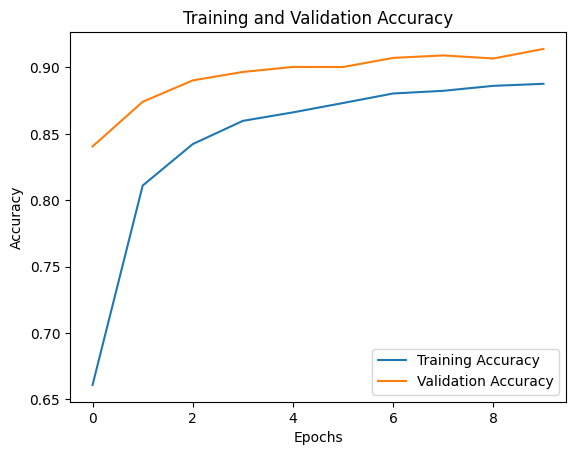

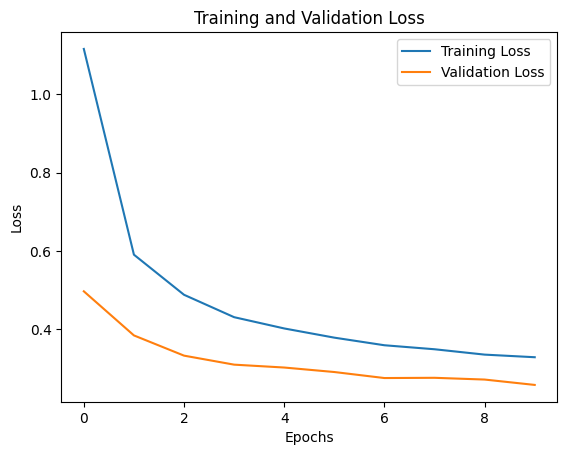

In [327]:
# Evaluate model accuracy on validation data
validation_accuracy = model.evaluate(validation_data_generator)[1]
print("Validation Accuracy:", validation_accuracy)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Optionally, plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Pre-Proccesing and Prediction

In [328]:
num_classes = len(class_mapping)
img_size = 28

data = pd.read_csv('emnist-letters-test.csv', header=None)
data_rows = len(data)
if not num_classes:
    num_classes = len(data[0].unique())

img_size = int(np.sqrt(len(data.iloc[0][1:])))

imgs = np.transpose(data.values[:,1:].reshape(data_rows, img_size, img_size, 1), axes=[0,2,1,3]) # img_size * img_size arrays

labels = keras.utils.to_categorical(data.values[:,0], num_classes)

X_test, y_test = imgs/255., labels

1/1 [==============================] - 0s 33ms/step


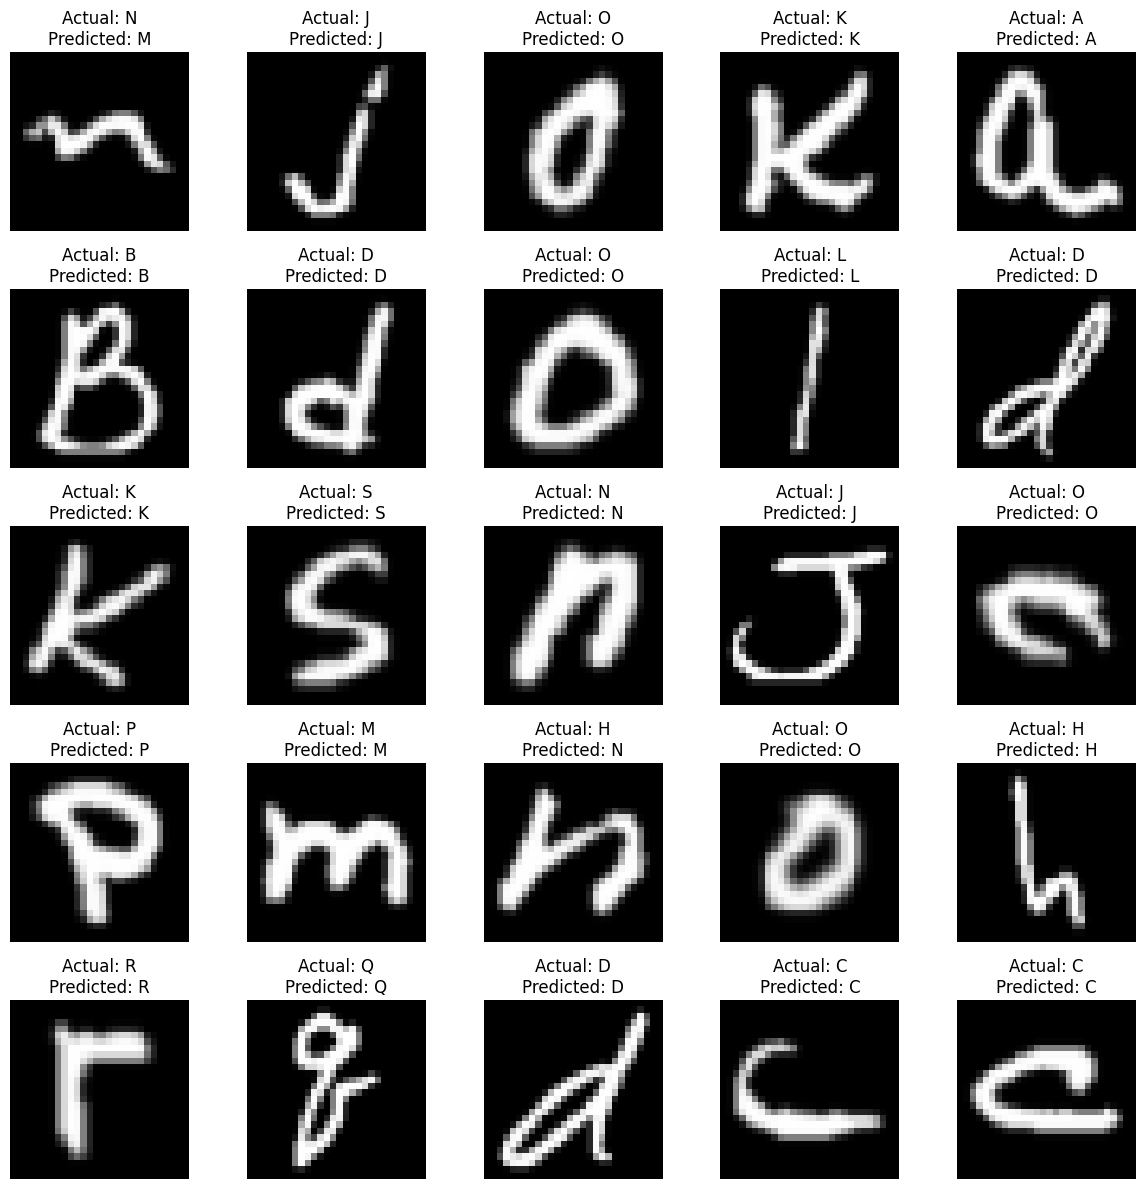

In [329]:
def show_example_and_predicted_val_test(n, predicted_n, ax):
    true_val = class_mapping[np.argmax(y_test[n])]  # The example's true label
    predicted_val = class_mapping[predicted_n]  # The predicted label

    ax.set_title("Actual: " + true_val + "\nPredicted: " + predicted_val)
    example_image = X_test[n].reshape(28, 28)  # Reshape the array to be a 28 by 28 matrix representing the actual image
    ax.imshow(example_image, cmap='gray')
    ax.axis('off')

# Define the size of the grid
num_rows = 5
num_cols = 5
num_images = num_rows * num_cols

# Create the grid of images and their predictions
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i in range(num_images):
    idx = random.randint(0, len(X_test))
    prediction = np.argmax(model.predict(X_test[idx:idx+1]))
    show_example_and_predicted_val_test(idx, prediction, axes[i // num_cols, i % num_cols])

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 46ms/step
Predicted characters array: D A N L E L M A R Z O


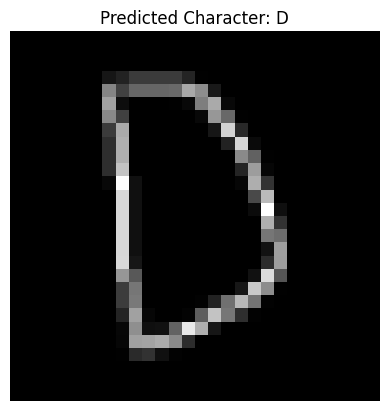

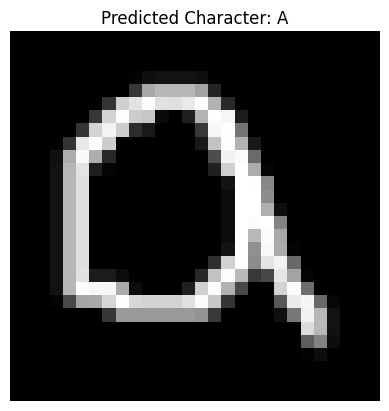

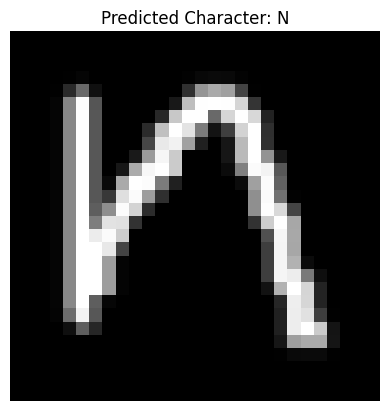

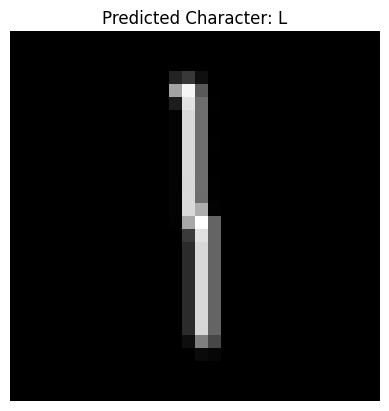

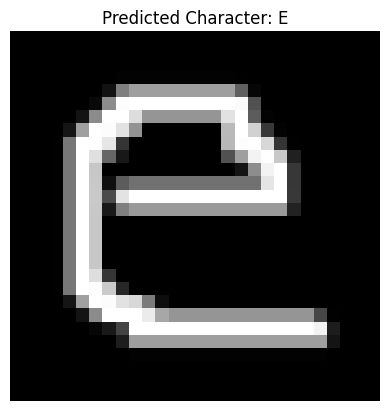

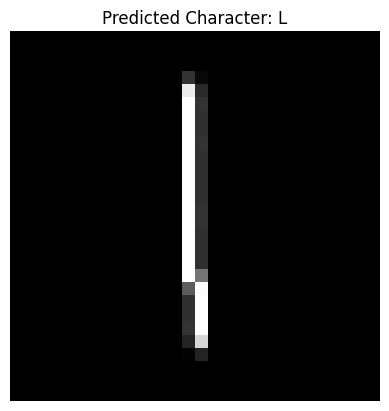

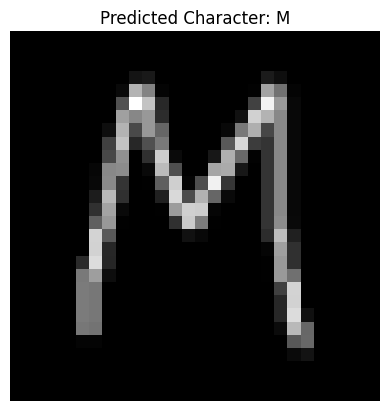

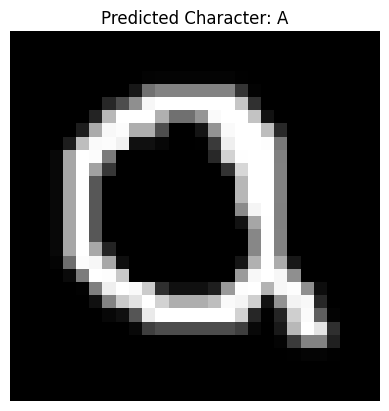

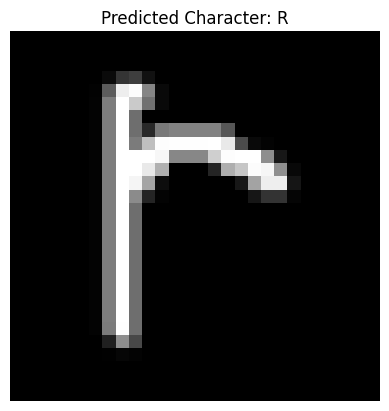

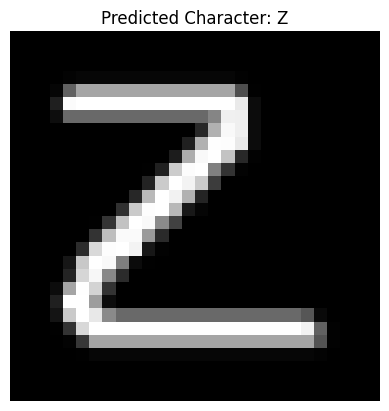

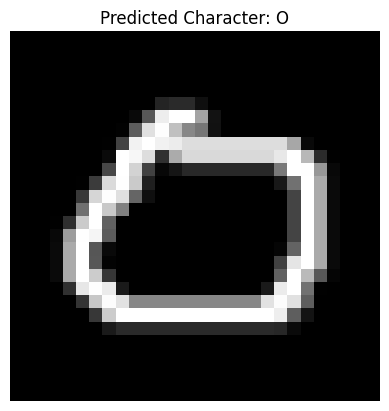

In [330]:
import cv2
import numpy as np
import imutils
from imutils.contours import sort_contours
import matplotlib.pyplot as plt

class_mapping = ' ABCDEFGHIJKLMNOPQRSTUVWXYZ'

def preprocess_and_extract_characters(image_path):
    # Load the input image from disk, convert it to grayscale, and blur it to reduce noise
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or path is incorrect")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Perform edge detection, find contours in the edge map, and sort the resulting contours from left-to-right
    edged = cv2.Canny(blurred, 30, 150)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]

    # Initialize the list of contour bounding boxes and associated characters that we'll be OCR'ing
    chars = []

    # Loop over the contours
    for c in cnts:
        # Compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)
        # Filter out bounding boxes, ensuring they are neither too small nor too large
        if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
            # Extract the character and threshold it to make the character appear as white (foreground) on a black background
            roi = gray[y:y + h, x:x + w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (tH, tW) = thresh.shape

            # Resize the extracted character to 28x28 pixels
            if tW > tH:
                thresh = imutils.resize(thresh, width=28)
            else:
                thresh = imutils.resize(thresh, height=28)

            # Re-grab the image dimensions (now that it's been resized) and determine how much we need to pad
            (tH, tW) = thresh.shape
            dX = int((28 - tW) / 2.0)
            dY = int((28 - tH) / 2.0)

            # Pad the image and force 28x28 dimensions
            padded = cv2.copyMakeBorder(thresh, top=dY + 5, bottom=dY + 5, left=dX + 5, right=dX + 5, borderType=cv2.BORDER_CONSTANT,
                                        value=(0, 0, 0))
            padded = cv2.resize(padded, (28, 28))

            # Prepare the padded image for classification
            padded = padded.astype("float32") / 255.0
            padded = np.expand_dims(padded, axis=0)  # Add batch dimension
            padded = np.expand_dims(padded, axis=-1)  # Add channel dimension

            # Update our list of characters that will be OCR'd
            chars.append((padded, (x, y, w, h)))

    return image, chars

def predict_characters(image, chars, model):
    predicted_chars = []

    # Loop over the characters and predict each one
    for char, _ in chars:
        # Predict the character using the model
        predicted_index = np.argmax(model.predict(char))
        predicted_letter = class_mapping[predicted_index]
        predicted_chars.append(predicted_letter)

    return predicted_chars

# Example usage
image_path = '/content/drive/MyDrive/Images/name.jpg'
original_image, extracted_chars = preprocess_and_extract_characters(image_path)
predicted_chars = predict_characters(original_image, extracted_chars, model)

# Display the characters in one line
print("Predicted characters array:", ' '.join(predicted_chars))

# Display the images in another line
for i, (char_image, _) in enumerate(extracted_chars):
    plt.imshow(char_image.squeeze(), cmap='gray')
    plt.title("Predicted Character: " + predicted_chars[i])
    plt.axis('off')
    plt.show()


# Saving Model

In [331]:
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
